In [1007]:
# general tools
import json
import glob
import os
import numpy as np


#data tools
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler

#ML tools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV



#visulaisation tools
import matplotlib.pyplot as plt
import seaborn as sns

## 1. import data
in the next section I use several data sets:
1. station data- data of the station, it give detail about the desires satiaon and the feature that we can get from each station
2. weather data- I downlad by api the meterological feature of the bet dagan station
3. cloud data - I download from ims website

In [347]:
# import the station data 
with open('C:\\Users\\Gal\\Desktop\\STUDYING\\לימוד נעים\\Mchal_student\\station_list.json') as f:
    data = json.load(f)
station_data = pd.DataFrame(data)

In [348]:
station_data[station_data['name']=='BET DAGAN']

,stationId,name,shortName,stationsTag,location,timebase,active,owner,regionId,monitors,StationTarget
29,54,BET DAGAN,BET DAGA,(null),"{'latitude': 32.009, 'longitude': 34.814}",10,True,ims,13,"[{'channelId': 1, 'name': 'Rain', 'alias': Non...",


In [349]:
station_data[station_data['name']=='BET DAGAN RAD']

,stationId,name,shortName,stationsTag,location,timebase,active,owner,regionId,monitors,StationTarget
45,85,BET DAGAN RAD,BET DAGA,(null),"{'latitude': None, 'longitude': None}",10,True,ims,13,"[{'channelId': 6, 'name': 'NIP', 'alias': None...",


## 1.1 import Bet-Dagan station 54 Data
previosuly I used api from the postman website to download 30 json files, each file contain one month of meteoroligcal details
afterward I convert the json format to Dataframe which we can work with it.


In [353]:
# import the bet dagan files from the database folder

path_to_json = 'C:\\Users\\Gal\\Desktop\\STUDYING\\לימוד נעים\\Mchal_student\\DataBase' #  path of the Datasets
json_pattern = os.path.join(path_to_json,'*.json')
file_list = glob.glob(json_pattern) # list of dataset paths
list_of_data_bd_54=[] # creat list wich contains the database of bet dagan

# the loop iterate over the file_list and import each file to the list_of_data_bd
for file in file_list:
    with open(file) as f:
        data = json.load(f)
    list_of_data_bd_54.append(pd.DataFrame.from_dict(data))
        


In [355]:
def row2DF_st54(df):

    """ the function pre-process the row data and convert to DF
    input: df- raw DataFrame
    return:  pre-processeed Dataframe
    """
    list_of_dic=[]
    for i in df['data']:
        dic=dict()
        data=(pd.DataFrame.from_dict(i))
        dic['time']=data['datetime'][0]
        dic['rain']=data['channels'][0]['value']
        dic['WSmax']=data['channels'][1]['value']
        dic['WDmax']=data['channels'][2]['value']
        dic['WS']=data['channels'][3]['value']
        dic['WD']=data['channels'][4]['value']
        dic['STDwd']=data['channels'][5]['value']
        dic['TD']=data['channels'][6]['value']
        dic['TDmax']=data['channels'][7]['value']
        dic['TDmin']=data['channels'][8]['value']
        dic['TG']=data['channels'][9]['value']
        dic['WS1mm']=data['channels'][10]['value']
        dic['Ws10mm']=data['channels'][11]['value']
        dic['RH']=data['channels'][13]['value']
        dic['BP']=data['channels'][14]['value']
        list_of_dic.append(dic)
    data=pd.DataFrame(list_of_dic)
    data['short_date']=data['time'].apply(lambda x: x[:13]) # create new column of short data
    return data

In [356]:
# create single DF of the features in station 54
list_of_pre_processed_data_bd_54=[]
num=0
for df in list_of_data_bd_54:

    list_of_pre_processed_data_bd_54.append(row2DF_st54(df))
data_general_bd=pd.concat(list_of_pre_processed_data_bd_54, axis=0)


In [357]:
data_general_bd

,time,rain,WSmax,WDmax,WS,WD,STDwd,TD,TDmax,TDmin,TG,WS1mm,Ws10mm,RH,BP,short_date
0,2020-12-01T00:00:00+02:00,0.0,2.5,110.0,2.1,115.0,4.5,12.6,12.6,12.5,11.6,2.3,2.3,97.0,1010.1,2020-12-01T00
1,2020-12-01T00:10:00+02:00,0.0,2.0,123.0,1.7,118.0,3.6,12.7,12.7,12.6,11.4,1.9,2.1,97.0,1010.0,2020-12-01T00
2,2020-12-01T00:20:00+02:00,0.0,1.9,126.0,1.2,128.0,4.6,12.6,12.7,12.6,11.4,1.7,1.7,97.0,1009.9,2020-12-01T00
3,2020-12-01T00:30:00+02:00,0.0,1.8,116.0,1.0,116.0,5.6,12.5,12.7,12.4,11.0,1.5,1.1,96.0,1009.9,2020-12-01T00
4,2020-12-01T00:40:00+02:00,0.0,1.8,130.0,1.4,124.0,4.2,12.4,12.4,12.3,10.7,1.6,1.5,96.0,1009.9,2020-12-01T00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4458,2021-01-31T23:10:00+02:00,0.0,1.7,111.0,1.3,108.0,5.1,10.7,10.8,10.7,9.2,1.6,1.7,96.0,1015.1,2021-01-31T23
4459,2021-01-31T23:20:00+02:00,0.0,1.4,122.0,1.1,108.0,8.6,10.6,10.7,10.5,9.0,1.3,1.2,96.0,1015.3,2021-01-31T23
4460,2021-01-31T23:30:00+02:00,0.0,1.6,133.0,1.2,128.0,4.3,10.3,10.5,10.3,8.8,1.5,1.3,96.0,1015.2,2021-01-31T23
4461,2021-01-31T23:40:00+02:00,0.0,1.3,125.0,1.1,127.0,3.0,10.3,10.3,10.2,8.6,1.2,1.2,97.0,1015.1,2021-01-31T23


## 1.2 import Bet-Dagan station 85 Data
previosuly I used api from the postman website to download 4 json files, each file contain one year of radiation details
afterward I convert the json format to Dataframe which we can work with it.


In [358]:
# import the bet dagan files from the database folder

path_to_json = 'C:\\Users\\Gal\\Desktop\\STUDYING\\לימוד נעים\\Mchal_student\\DataBase_85*' #  path of the Datasets
json_pattern = os.path.join(path_to_json,'*.json')
file_list = glob.glob(json_pattern) # list of dataset paths
list_of_data_bd=[] # creat list wich contains the database of bet dagan

# the loop iterate over the file_list and import each file to the list_of_data_bd
for file in file_list:
    with open(file) as f:
        data = json.load(f)
    list_of_data_bd.append(pd.DataFrame.from_dict(data))
        

In [359]:
def row2DF_st85(df):

    """ the function pre-process the row data and convert to DF
    input: df- raw DataFrame
    return:  pre-processeed Dataframe
    """
    list_of_dic=[]
    for i in df['data']:
        dic=dict()
        data=(pd.DataFrame.from_dict(i))
        dic['time']=data['datetime'][0]
        dic['NIP']=data['channels'][0]['value']
        dic['Grad']=data['channels'][1]['value']
        dic['DiffR']=data['channels'][2]['value']
        list_of_dic.append(dic)
    data=pd.DataFrame(list_of_dic)
    data['short_date']=data['time'].apply(lambda x: x[:13]) # create new column of short data
    return data

In [360]:
# create single DF of data_rad_bd
list_of_pre_processed_data_bd_85=[]
for df in list_of_data_bd:
    list_of_pre_processed_data_bd_85.append(row2DF_st85(df))
data_rad_bd=pd.concat(list_of_pre_processed_data_bd_85, axis=0)


In [361]:
data_rad_bd

,time,NIP,Grad,DiffR,short_date
0,2020-09-01T00:00:00+03:00,0.0,0.0,0.0,2020-09-01T00
1,2020-09-01T00:10:00+03:00,0.0,0.0,0.0,2020-09-01T00
2,2020-09-01T00:20:00+03:00,0.0,0.0,0.0,2020-09-01T00
3,2020-09-01T00:30:00+03:00,0.0,0.0,0.0,2020-09-01T00
4,2020-09-01T00:40:00+03:00,0.0,0.0,0.0,2020-09-01T00
...,...,...,...,...,...
13069,2013-11-30T23:10:00+02:00,0.0,0.0,0.0,2013-11-30T23
13070,2013-11-30T23:20:00+02:00,0.0,0.0,0.0,2013-11-30T23
13071,2013-11-30T23:30:00+02:00,1.0,0.0,0.0,2013-11-30T23
13072,2013-11-30T23:40:00+02:00,1.0,0.0,0.0,2013-11-30T23


## 1.3 import Bet-Dagan station clouds data
the next section I use the structured api from the ims.co.il
I define the variables and downoad as csv file


In [374]:
# import the bet dagan  data of cluds and concatenate it to single DF

path = 'C:\\Users\\Gal\\Desktop\\STUDYING\\לימוד נעים\\Mchal_student\\clouds*' # use your path
all_files = glob.glob(os.path.join(path , "*.csv"))

list_data_clouds = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    list_data_clouds.append(df)

data_clouds_bd = pd.concat(list_data_clouds, axis=0)
data_clouds_bd['short_date']=data_clouds_bd['Date & Time (Winter)'].apply(lambda x: x[6:10]+'-'+x[3:5]+'-'+x[0:2]+'T'+x[11:13])

In [375]:
data_clouds_bd

,Station,Date & Time (Winter),Total clouds cover (code),Total low clouds cover (code),Low clouds base (code),Low clouds type (code),Medium clouds type (code),Hight clouds type (code),Visibility (code),short_date
0,Bet Dagan Man 01/1964-11/2022,01/09/2013 02:00,3.0,3.0,5.0,5.0,0.0,0.0,60.0,2013-09-01T02
1,Bet Dagan Man 01/1964-11/2022,01/09/2013 05:00,1.0,1.0,5.0,5.0,0.0,0.0,60.0,2013-09-01T05
2,Bet Dagan Man 01/1964-11/2022,01/09/2013 08:00,1.0,1.0,6.0,1.0,0.0,0.0,60.0,2013-09-01T08
3,Bet Dagan Man 01/1964-11/2022,01/09/2013 11:00,5.0,5.0,6.0,1.0,0.0,0.0,70.0,2013-09-01T11
4,Bet Dagan Man 01/1964-11/2022,01/09/2013 14:00,2.0,2.0,6.0,1.0,0.0,0.0,70.0,2013-09-01T14
...,...,...,...,...,...,...,...,...,...,...
24049,Bet Dagan Man 01/1964-11/2022,30/11/2021 11:00,5.0,0.0,9.0,0.0,0.0,4.0,65.0,2021-11-30T11
24050,Bet Dagan Man 01/1964-11/2022,30/11/2021 14:00,6.0,0.0,9.0,0.0,0.0,6.0,70.0,2021-11-30T14
24051,Bet Dagan Man 01/1964-11/2022,30/11/2021 17:00,6.0,0.0,9.0,0.0,0.0,8.0,60.0,2021-11-30T17
24052,Bet Dagan Man 01/1964-11/2022,30/11/2021 20:00,5.0,4.0,4.0,8.0,0.0,1.0,60.0,2021-11-30T20


## 1.4 merge the Datasets
in the next section I'll merge the three datasets


In [479]:
merged_data=pd.merge(data_general_bd, data_rad_bd, on='time')
merged_data['short_date']=merged_data['short_date_x']

In [480]:
merged_data

,time,rain,WSmax,WDmax,WS,WD,STDwd,TD,TDmax,TDmin,...,WS1mm,Ws10mm,RH,BP,short_date_x,NIP,Grad,DiffR,short_date_y,short_date
0,2020-12-01T00:00:00+02:00,0.0,2.5,110.0,2.1,115.0,4.5,12.6,12.6,12.5,...,2.3,2.3,97.0,1010.1,2020-12-01T00,0.0,0.0,0.0,2020-12-01T00,2020-12-01T00
1,2020-12-01T00:10:00+02:00,0.0,2.0,123.0,1.7,118.0,3.6,12.7,12.7,12.6,...,1.9,2.1,97.0,1010.0,2020-12-01T00,0.0,0.0,0.0,2020-12-01T00,2020-12-01T00
2,2020-12-01T00:20:00+02:00,0.0,1.9,126.0,1.2,128.0,4.6,12.6,12.7,12.6,...,1.7,1.7,97.0,1009.9,2020-12-01T00,0.0,0.0,0.0,2020-12-01T00,2020-12-01T00
3,2020-12-01T00:30:00+02:00,0.0,1.8,116.0,1.0,116.0,5.6,12.5,12.7,12.4,...,1.5,1.1,96.0,1009.9,2020-12-01T00,0.0,0.0,0.0,2020-12-01T00,2020-12-01T00
4,2020-12-01T00:40:00+02:00,0.0,1.8,130.0,1.4,124.0,4.2,12.4,12.4,12.3,...,1.6,1.5,96.0,1009.9,2020-12-01T00,0.0,0.0,0.0,2020-12-01T00,2020-12-01T00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278252,2021-01-31T23:10:00+02:00,0.0,1.7,111.0,1.3,108.0,5.1,10.7,10.8,10.7,...,1.6,1.7,96.0,1015.1,2021-01-31T23,0.0,0.0,0.0,2021-01-31T23,2021-01-31T23
278253,2021-01-31T23:20:00+02:00,0.0,1.4,122.0,1.1,108.0,8.6,10.6,10.7,10.5,...,1.3,1.2,96.0,1015.3,2021-01-31T23,0.0,0.0,0.0,2021-01-31T23,2021-01-31T23
278254,2021-01-31T23:30:00+02:00,0.0,1.6,133.0,1.2,128.0,4.3,10.3,10.5,10.3,...,1.5,1.3,96.0,1015.2,2021-01-31T23,0.0,0.0,0.0,2021-01-31T23,2021-01-31T23
278255,2021-01-31T23:40:00+02:00,0.0,1.3,125.0,1.1,127.0,3.0,10.3,10.3,10.2,...,1.2,1.2,97.0,1015.1,2021-01-31T23,0.0,0.0,0.0,2021-01-31T23,2021-01-31T23


In [482]:
merged_data=merged_data.merge(data_clouds_bd,on='short_date', how='outer')

In [483]:
merged_data

,time,rain,WSmax,WDmax,WS,WD,STDwd,TD,TDmax,TDmin,...,short_date,Station,Date & Time (Winter),Total clouds cover (code),Total low clouds cover (code),Low clouds base (code),Low clouds type (code),Medium clouds type (code),Hight clouds type (code),Visibility (code)
0,2020-12-01T00:00:00+02:00,0.0,2.5,110.0,2.1,115.0,4.5,12.6,12.6,12.5,...,2020-12-01T00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-12-01T00:10:00+02:00,0.0,2.0,123.0,1.7,118.0,3.6,12.7,12.7,12.6,...,2020-12-01T00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-12-01T00:20:00+02:00,0.0,1.9,126.0,1.2,128.0,4.6,12.6,12.7,12.6,...,2020-12-01T00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-12-01T00:30:00+02:00,0.0,1.8,116.0,1.0,116.0,5.6,12.5,12.7,12.4,...,2020-12-01T00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-12-01T00:40:00+02:00,0.0,1.8,130.0,1.4,124.0,4.2,12.4,12.4,12.3,...,2020-12-01T00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-11-30T11,Bet Dagan Man 01/1964-11/2022,30/11/2021 11:00,5.0,0.0,9.0,0.0,0.0,4.0,65.0
287120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-11-30T14,Bet Dagan Man 01/1964-11/2022,30/11/2021 14:00,6.0,0.0,9.0,0.0,0.0,6.0,70.0
287121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-11-30T17,Bet Dagan Man 01/1964-11/2022,30/11/2021 17:00,6.0,0.0,9.0,0.0,0.0,8.0,60.0
287122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-11-30T20,Bet Dagan Man 01/1964-11/2022,30/11/2021 20:00,5.0,4.0,4.0,8.0,0.0,1.0,60.0


## 2. Data Cleaning

in the next section I will check the next things:
1. nulls
2. data types
3. create column of months
3. dummy features


### 2.1 null values
in the next section I examine the null value of the data
first I groupby the data from 10 mins to 1 hour freuqecny. I use groupby by mean, max and sum as function of the feature attribute, for example the rain is groupby with sum method, the max wind speed is groupby with max method etc. the detail is shown in the code

Becouse the data of the cloud feature is so relevant to the model ( as we see during the analysis and also rare9 we get detail every 3 hours, in contrast to other feature which we get sanmple each one hour. I tried to use  imputation method to backfil only one row of the clouds features  but it decrease the model perfprmance

I decide to make a A conservative model and drop all the rows which dont contain the clouds data, we can see in the next EDA section that clouds are important feature and have positive coorelation with rain



Text(0.5, 1.0, '2.1.1 Null distibution')

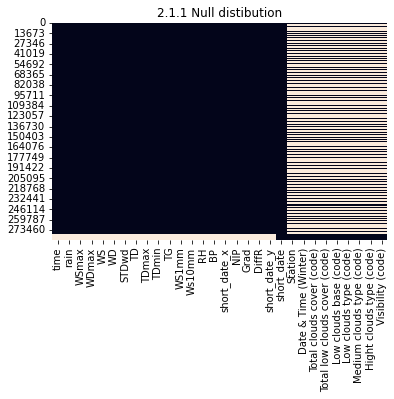

In [484]:
sns.heatmap(merged_data.isnull(), cbar=False)
plt.title("2.1.1 Null distibution")

In [705]:
#groupby with diffrent methos as its shown
gb_data=merged_data.groupby('short_date').agg({'rain':'sum', 'WSmax':'max','WDmax':"max",'WS':'mean','WD':'mean',
                                               'STDwd':'mean', 'TD':'mean', 'TDmax':"max",
       'TDmin':'min', 'TG':'mean', 'WS1mm':'mean', 'Ws10mm':'mean', 'RH':'mean', 'BP':'mean', 'NIP':'mean',
       'Grad':'mean', 'DiffR':'mean',
        'Total clouds cover (code)':'mean',
       'Total low clouds cover (code)':'mean', 'Low clouds base (code)':'mean',
       'Low clouds type (code)':'mean', 'Medium clouds type (code)':'mean',
       'Hight clouds type (code)':'mean', 'Visibility (code)':'mean'})

In [706]:
gb_data

,rain,WSmax,WDmax,WS,WD,STDwd,TD,TDmax,TDmin,TG,...,NIP,Grad,DiffR,Total clouds cover (code),Total low clouds cover (code),Low clouds base (code),Low clouds type (code),Medium clouds type (code),Hight clouds type (code),Visibility (code)
short_date,,,,,,,,,,,,,,,,,,,,,
2013-09-01T00,0.0,3.5,163.0,2.016667,157.333333,7.733333,24.766667,25.1,24.4,24.150000,...,1.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-09-01T01,0.0,4.5,167.0,2.266667,155.000000,10.066667,24.233333,24.5,24.0,23.716667,...,0.666667,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-09-01T02,0.0,4.2,174.0,2.300000,163.166667,10.350000,24.450000,24.5,24.2,24.133333,...,1.000000,0.0,0.0,3.0,3.0,5.0,5.0,0.0,0.0,60.0
2013-09-01T03,0.0,3.8,189.0,2.016667,173.166667,11.400000,24.500000,24.6,24.4,24.050000,...,0.666667,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-09-01T04,0.0,4.0,190.0,2.016667,171.166667,9.150000,24.183333,24.4,23.8,23.433333,...,0.166667,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30T11,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,0.0,9.0,0.0,0.0,4.0,65.0
2021-11-30T14,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.0,0.0,9.0,0.0,0.0,6.0,70.0
2021-11-30T17,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6.0,0.0,9.0,0.0,0.0,8.0,60.0


Text(0.5, 1.0, '2.1.2 Null distibution after groupby ')

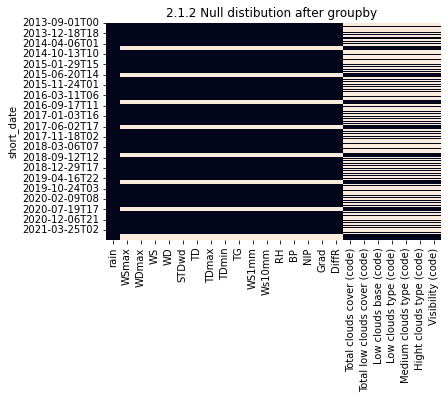

In [708]:
sns.heatmap(gb_data.isnull(), cbar=False)
plt.title("2.1.2 Null distibution after groupby ")

In [709]:
gb_data.isna().sum()

rain                                 0
WSmax                             8867
WDmax                             8867
WS                                8867
WD                                8867
STDwd                             8867
TD                                8867
TDmax                             8867
TDmin                             8867
TG                                8867
WS1mm                             8867
Ws10mm                            8867
RH                                8867
BP                                8867
NIP                               8867
Grad                              8867
DiffR                             8867
Total clouds cover (code)        30507
Total low clouds cover (code)    30515
Low clouds base (code)           30508
Low clouds type (code)           30515
Medium clouds type (code)        30516
Hight clouds type (code)         30518
Visibility (code)                30482
dtype: int64

In [710]:
# # imputation with backfill and ffill - only single row will be fill
# gb_data.fillna(method='backfill',limit=1,inplace=True)
# gb_data.fillna(method='ffill',limit=1,inplace=True)

In [711]:
gb_data.dropna(thresh=20,inplace=True)

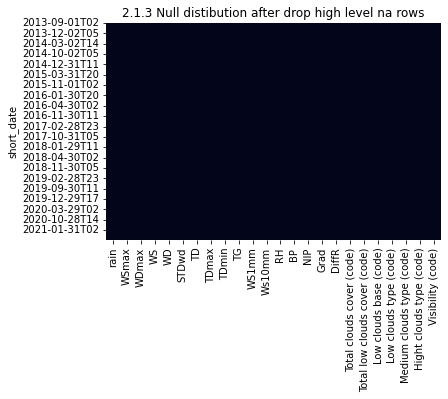

In [712]:
sns.heatmap(gb_data.isnull(), cbar=False)
plt.title("2.1.3 Null distibution after drop high level na rows");

In [713]:
gb_data.isna().sum()

rain                             0
WSmax                            0
WDmax                            0
WS                               0
WD                               0
STDwd                            0
TD                               0
TDmax                            0
TDmin                            0
TG                               0
WS1mm                            0
Ws10mm                           0
RH                               0
BP                               0
NIP                              0
Grad                             0
DiffR                            0
Total clouds cover (code)        0
Total low clouds cover (code)    5
Low clouds base (code)           0
Low clouds type (code)           5
Medium clouds type (code)        5
Hight clouds type (code)         6
Visibility (code)                4
dtype: int64

In [809]:
gb_data=gb_data.fillna(gb_data.median())

In [810]:
gb_data.isna().sum().sum()

0

In [811]:
gb_data

,rain,WSmax,WDmax,WS,WD,STDwd,TD,TDmax,TDmin,TG,...,Grad,DiffR,Total clouds cover (code),Total low clouds cover (code),Low clouds base (code),Low clouds type (code),Medium clouds type (code),Hight clouds type (code),Visibility (code),month
short_date,,,,,,,,,,,,,,,,,,,,,
2013-09-01T02,0.0,4.2,174.0,2.300000,163.166667,10.350000,24.450000,24.5,24.2,24.133333,...,0.000000,0.000000,3.0,3.0,5.0,5.0,0.0,0.0,60.0,09
2013-09-01T05,0.0,5.4,175.0,2.866667,159.500000,10.550000,23.800000,24.0,23.7,23.366667,...,9.333333,7.666667,1.0,1.0,5.0,5.0,0.0,0.0,60.0,09
2013-09-01T08,0.0,5.9,195.0,3.133333,171.833333,14.600000,28.166667,28.8,27.6,33.900000,...,449.500000,219.666667,1.0,1.0,6.0,1.0,0.0,0.0,60.0,09
2013-09-01T11,0.0,7.6,283.0,4.816667,263.000000,16.383333,31.716667,32.4,31.0,41.833333,...,826.333333,237.833333,5.0,5.0,6.0,1.0,0.0,0.0,70.0,09
2013-09-01T14,0.0,8.3,298.0,4.316667,275.166667,18.416667,31.466667,31.9,31.0,39.716667,...,635.333333,157.000000,2.0,2.0,6.0,1.0,0.0,0.0,70.0,09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30T11,0.0,5.6,287.0,3.266667,264.333333,17.416667,28.100000,28.6,27.3,39.200000,...,965.166667,184.500000,0.0,0.0,9.0,0.0,0.0,0.0,60.0,04
2021-04-30T14,0.0,7.8,352.0,4.216667,327.500000,16.033333,27.150000,27.6,26.5,36.333333,...,751.000000,164.000000,1.0,0.0,9.0,0.0,0.0,1.0,60.0,04
2021-04-30T17,0.0,6.1,350.0,3.366667,238.500000,14.183333,26.450000,26.6,26.0,28.183333,...,143.000000,69.333333,0.0,0.0,9.0,0.0,0.0,0.0,60.0,04


### 2.2 data type
in the next section Ill examine the data type and change the data in order to work more comfortabely with the data 
it find out that all the data are float, thus we dont need to change here the data


In [812]:
gb_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15159 entries, 2013-09-01T02 to 2021-04-30T23
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   rain                           15159 non-null  float64
 1   WSmax                          15159 non-null  float64
 2   WDmax                          15159 non-null  float64
 3   WS                             15159 non-null  float64
 4   WD                             15159 non-null  float64
 5   STDwd                          15159 non-null  float64
 6   TD                             15159 non-null  float64
 7   TDmax                          15159 non-null  float64
 8   TDmin                          15159 non-null  float64
 9   TG                             15159 non-null  float64
 10  WS1mm                          15159 non-null  float64
 11  Ws10mm                         15159 non-null  float64
 12  RH                             

### 2.3 Month feature
 in the next section I'll create month feature - it can give us meaningful feature, which we know the there are more rainy months and there are diffrent metotrological features for rain in diffrence month for example tin september theere can be raingn wven with hight teprature (rare) and its no common in january
 
in the next anayisis we will assign the column with dummy features

In [813]:
gb_data.loc[:,'month']=gb_data.index
gb_data.loc[:,'month']=gb_data.loc[:,'month'].apply(lambda x: x[5:7])

In [814]:
gb_data

,rain,WSmax,WDmax,WS,WD,STDwd,TD,TDmax,TDmin,TG,...,Grad,DiffR,Total clouds cover (code),Total low clouds cover (code),Low clouds base (code),Low clouds type (code),Medium clouds type (code),Hight clouds type (code),Visibility (code),month
short_date,,,,,,,,,,,,,,,,,,,,,
2013-09-01T02,0.0,4.2,174.0,2.300000,163.166667,10.350000,24.450000,24.5,24.2,24.133333,...,0.000000,0.000000,3.0,3.0,5.0,5.0,0.0,0.0,60.0,09
2013-09-01T05,0.0,5.4,175.0,2.866667,159.500000,10.550000,23.800000,24.0,23.7,23.366667,...,9.333333,7.666667,1.0,1.0,5.0,5.0,0.0,0.0,60.0,09
2013-09-01T08,0.0,5.9,195.0,3.133333,171.833333,14.600000,28.166667,28.8,27.6,33.900000,...,449.500000,219.666667,1.0,1.0,6.0,1.0,0.0,0.0,60.0,09
2013-09-01T11,0.0,7.6,283.0,4.816667,263.000000,16.383333,31.716667,32.4,31.0,41.833333,...,826.333333,237.833333,5.0,5.0,6.0,1.0,0.0,0.0,70.0,09
2013-09-01T14,0.0,8.3,298.0,4.316667,275.166667,18.416667,31.466667,31.9,31.0,39.716667,...,635.333333,157.000000,2.0,2.0,6.0,1.0,0.0,0.0,70.0,09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30T11,0.0,5.6,287.0,3.266667,264.333333,17.416667,28.100000,28.6,27.3,39.200000,...,965.166667,184.500000,0.0,0.0,9.0,0.0,0.0,0.0,60.0,04
2021-04-30T14,0.0,7.8,352.0,4.216667,327.500000,16.033333,27.150000,27.6,26.5,36.333333,...,751.000000,164.000000,1.0,0.0,9.0,0.0,0.0,1.0,60.0,04
2021-04-30T17,0.0,6.1,350.0,3.366667,238.500000,14.183333,26.450000,26.6,26.0,28.183333,...,143.000000,69.333333,0.0,0.0,9.0,0.0,0.0,0.0,60.0,04


### 2.4 dummy features
in the next section I create dummy variable for the next features :Low clouds type, meduim clouds type and high clouds type
its importnat to mention that the features Total clouds cover (code), Total low clouds cover (code) and Low clouds base (code) are categorical also, but there is a linear meaning in the code( for example: 8 clouds cover mean all the sky cover with clouds and 1 clouds cover mean 1/8 of the sky cover with clouds)

Furthermore I create dummy variable for the month feature

In [815]:
gb_df = pd.get_dummies(gb_data, columns=['Low clouds type (code)','Medium clouds type (code)','Hight clouds type (code)','month'])

## 3. EDA

<AxesSubplot:>

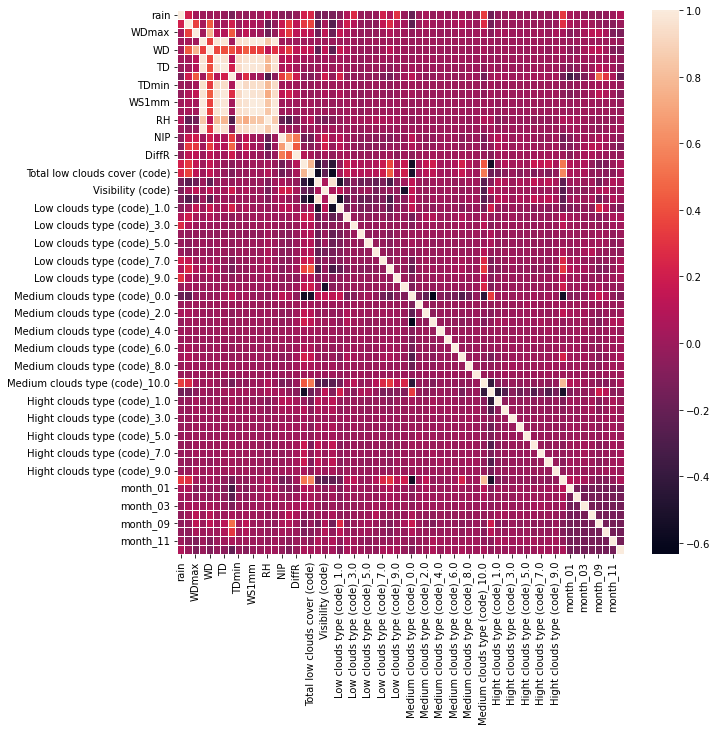

In [789]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

sns.heatmap(gb_df.corr(), linewidths=.5, ax=ax)

## 4 Data enigneering
### 4.1  create target column
in the next section I define the target column as the rain, and it will have 3 categoris:
0- dry
1- Slight rain 0-0.5 mm
2- rain 0.5> mm

In [817]:
gb_df['rain']=gb_df['rain'].apply(lambda x:0 if x<0.1 else 2 if x>1 else 1 )
# gb_df['rain']=gb_df['rain'].apply(lambda x:0 if x<0.01 else 1)

### 4.2  Imbalance target
the data is extremely imblanced, it can hurt the model, thus I use undersampling and oversampling method in order to get balanced data in a way that we will not insert too much bias to the data

I choose SMOTE  becouse I assume that the rain data has high similairity in the space of the features 
https://imbalanced-learn.org/stable/references/under_sampling.html

Text(0.5, 1.0, 'Target data distribution')

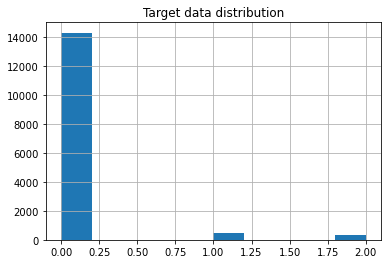

In [818]:
gb_df['rain'].hist()
plt.title("Target data distribution")

In [970]:
# create X and y data sets
X=gb_df.drop(columns='rain')
y=gb_df['rain']

# Initial split of the data, I split it before the oversample in order to examine if the oversample overfit the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# I use SMOTE metohd to oversample the Data
rus=RandomUnderSampler(sampling_strategy={0:1000})
X_ures, y_ures=rus.fit_resample(X_train, y_train)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_ures, y_ures)

Text(0.5, 1.0, 'Target data distribution after over-sampling')

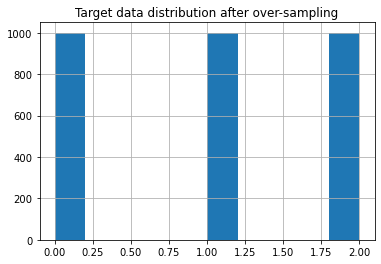

In [971]:
y_res.hist()
plt.title("Target data distribution after over-sampling")

### 4.3  data standardization 
I use sandartization in order to get better score model


In [972]:
# split the data into train and validation  
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.20, random_state=42)

# I use StandardScaler method in order to standartize the data
scaler = preprocessing.StandardScaler()
X_train_std=scaler.fit_transform(X_train) 
X_train_std=pd.DataFrame(X_train_std,columns=X_train.columns)

# i transform the x_val and x_test data as the scalar attribute of the train data
X_val_std=pd.DataFrame(scaler.transform(X_val),columns=X_val.columns)
X_test_std=pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

## 5. Train Classification  ML model 

Ill examine 4 diffrent classifier methods:
    RandomForestClassifier
    AdaBoostClassifier
    XGBoostClassifier
    KNeighborsClassifier
I examine each model over the standatization Data and over the non-standartization Data

In [1002]:
clf0=RandomForestClassifier()
clf0.fit(X_train,y_train)
y_pred=clf0.predict(X_val)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       217
           1       0.86      0.88      0.87       202
           2       0.90      0.91      0.91       181

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600



In [991]:
clf1=RandomForestClassifier()
clf1.fit(X_train_std,y_train)
y_pred=clf1.predict(X_val_std)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       217
           1       0.87      0.86      0.86       202
           2       0.88      0.92      0.90       181

    accuracy                           0.91       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.91      0.91      0.91       600



In [994]:
clf2=AdaBoostClassifier()
clf2.fit(X_train,y_train)
y_pred=clf2.predict(X_val)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       217
           1       0.68      0.64      0.66       202
           2       0.69      0.74      0.71       181

    accuracy                           0.78       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.78      0.78      0.78       600



In [995]:
clf3=AdaBoostClassifier()
clf3.fit(X_train_std,y_train)
y_pred=clf3.predict(X_val_std)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       217
           1       0.68      0.64      0.66       202
           2       0.69      0.74      0.71       181

    accuracy                           0.78       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.78      0.78      0.78       600



In [996]:
clf4= XGBClassifier(max_depth=5,min_child_weight=5, n_estimators=200,gamma=1)
clf4.fit(X_train,y_train)
y_pred=clf4.predict(X_val)
print(classification_report(y_val,y_pred))

C:\Users\Gal\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gal\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:35:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       217
           1       0.87      0.84      0.85       202
           2       0.87      0.92      0.89       181

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.90      0.90       600



In [997]:
clf5= XGBClassifier(max_depth=5,min_child_weight=5, n_estimators=200,gamma=1)
clf5.fit(X_train_std,y_train)
y_pred=clf5.predict(X_val_std)
print(classification_report(y_val,y_pred))

[21:35:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Gal\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Gal\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


              precision    recall  f1-score   support

           0       0.95      0.94      0.94       217
           1       0.87      0.84      0.85       202
           2       0.87      0.92      0.89       181

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.90      0.90       600



In [998]:
clf6= KNeighborsClassifier()
clf6.fit(X_train,y_train)
y_pred=clf6.predict(X_val)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89       217
           1       0.76      0.86      0.81       202
           2       0.82      0.86      0.84       181

    accuracy                           0.84       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.86      0.84      0.85       600



In [999]:
clf7= KNeighborsClassifier()
clf7.fit(X_train_std,y_train)
y_pred=clf7.predict(X_val_std)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       217
           1       0.67      0.60      0.63       202
           2       0.67      0.72      0.69       181

    accuracy                           0.75       600
   macro avg       0.74      0.75      0.74       600
weighted avg       0.75      0.75      0.75       600



In [1005]:
##best score model: clf0
y_pred=clf0.predict(X_val)
confusion_matrix(y_val,y_pred)

array([[202,  15,   0],
       [  6, 178,  18],
       [  2,  14, 165]], dtype=int64)

## 5. Hyper parameter optimization
I got help form the next ewebsite https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [1008]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [1011]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 20, cv = 5, verbose=3, random_state=42, n_jobs = -1)
# Fit the random search model
clf_random.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=3)

In [1012]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [1016]:
y_pred=rf_random.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      2875
           1       0.20      0.73      0.31        91
           2       0.67      0.71      0.69        66

    accuracy                           0.90      3032
   macro avg       0.62      0.78      0.65      3032
weighted avg       0.96      0.90      0.93      3032



In [1017]:
confusion_matrix(y_test,y_pred)

array([[2615,  252,    8],
       [  10,   66,   15],
       [   1,   18,   47]], dtype=int64)

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

### 5. Evaluation



## 6. ML model analysis

## 7. Conclusions

# 8. refernece
explanation of the features and clouds code
https://ims.gov.il/sites/default/files/2020-10/%D7%94%D7%A1%D7%91%D7%A8%D7%9C%D7%A7%D7%91%D7%A6%D7%99%D7%9E%D7%98%D7%94%D7%93%D7%98%D7%94%D7%A0%D7%AA%D7%95%D7%A0%D7%99%D7%9D%D7%A2%D7%A9%D7%A8%D7%93%D7%A7%D7%AA%D7%99%D7%99%D7%9D.pdf

In [595]:
import io
from IPython.nbformat import current

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print(word_count)

ModuleNotFoundError: No module named 'IPython.nbformat'

In [695]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=42)

In [696]:
clf=RandomForestClassifier(max_depth=11)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_train)

In [697]:
confusion_matrix(y_train,y_pred)

array([[10444,   270],
       [    7, 10777]], dtype=int64)

In [698]:
y_pred=clf.predict(X_test)

confusion_matrix(y_test,y_pred)

array([[3453,  165],
       [  41, 3507]], dtype=int64)